<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/330_Detectron2_Instance_3D_EM_Platelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/cEgF0YknpZw

# **Prepare environment**

Create your own dataset by annotating for object detection using your favorite annotation software that can export annotations as COCO JSON format. I have used https://www.makesense.ai/ for my tutorial. I used the polygon tool to annotate objects and exported annotations as, "Single file in COCO JSON format"

## Install Detectron2

In [ ]:
python -m pip install -e .

In [1]:
!python3 -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone https://github.com/facebookresearch/detectron2.git
dist = distutils.core.run_setup("./detectron2/setup.py")
!python3 -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# python -m pip install git+https://github.com/facebookresearch/detectron2.git

fatal: destination path 'detectron2' already exists and is not an empty directory.


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


import detectron2
print(detectron2.__file__)

zsh:1: command not found: nvcc
torch:  2.1 ; cuda:  2.1.1
detectron2: 0.6
/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/detectron2/detectron2/__init__.py


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.pyplot as plt

# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

matplotlib data path: /Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data
CONFIGDIR=/Users/holmes/.matplotlib
interactive is False
platform is darwin
CACHEDIR=/Users/holmes/.matplotlib
Using fontManager instance from /Users/holmes/.matplotlib/fontlist-v330.json
Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


## Test on image

The default models are trained on natural images so let us go ahead and load a natural image to see if detectron is working. **We will run a pre-trained model on this image.**

Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
findfont: score(FontEntry(fname='/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'))

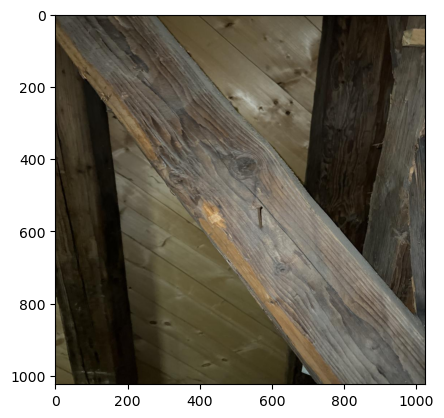

In [4]:
image_path = r"/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/3_iphone_domini_seg/Dominik-seg.v4i.coco-segmentation/test/Model_3_0037_jpeg.rf.7021068cda424cd59facf6d2f3399763.jpg"
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# cv2.imshow("image", image)

We create a detectron2 config and a detectron2 DefaultPredictor to run inference on this image.

In [6]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(image)

[06/27 14:02:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:13, 13.5MB/s]                            

Successfully downloaded /Users/holmes/.torch/iopath_cache/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl. 177841981 bytes.
URL https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl cached in /Users/holmes/.torch/iopath_cache/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
[Checkpointer] Loading from /Users/holmes/.torch/iopath_cache/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
Reading a file from 'Detectron2 Model Zoo'



/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
# look at the outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([], dtype=torch.int64)
Boxes(tensor([], size=(0, 4)))


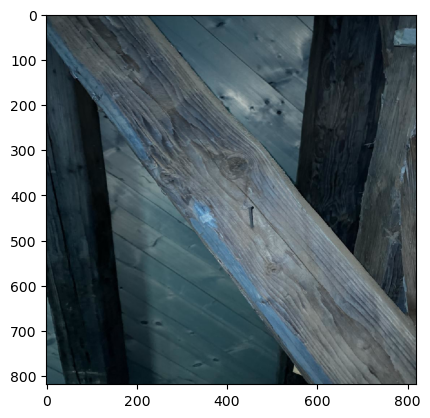

In [8]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

# **Preparation Data**

## *Server*

### Data loader(server)

Import the necessary function to register datasets in the COCO format. Let us register both the training and validation datasets. Please note that we are working with training (and validation) data that is is the coco format where we have a single JSON file that describes all the annotations from all training images. <p>
Here, we are naming our training data as 'my_dataset_train' and the validation data as 'my_dataset_val'.



In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wood_train", {}, "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train/_annotations.coco.json", "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train")
register_coco_instances("wood_val", {}, "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid/_annotations.coco.json", "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid")
register_coco_instances("wood_test", {}, "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test/_annotations.coco.json", "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test")


train_metadata = MetadataCatalog.get("wood_train")
train_dataset_dicts = DatasetCatalog.get("wood_train")

val_metadata = MetadataCatalog.get("wood_val")
val_dataset_dicts = DatasetCatalog.get("wood_val")

test_metadata = MetadataCatalog.get("wood_test")
test_dataset_dicts = DatasetCatalog.get("wood_test")


WARNING [06/21 19:34:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/21 19:34:43 d2.data.datasets.coco]: Loaded 1113 images in COCO format from /mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train/_annotations.coco.json
WARNING [06/21 19:34:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/21 19:34:43 d2.data.datasets.coco]: Loaded 107 images in COCO format from /mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid/_annotations.coco.json
WARNING [06/21 19:34:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/21 19:34:43 d2.data.datasets.coco]: Loaded 104 images in COCO format from /mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test/_annotations.coco.json


### Check sample(server)

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/jpan/miniconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/jpan/miniconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/jpan/miniconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/jpan/miniconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='

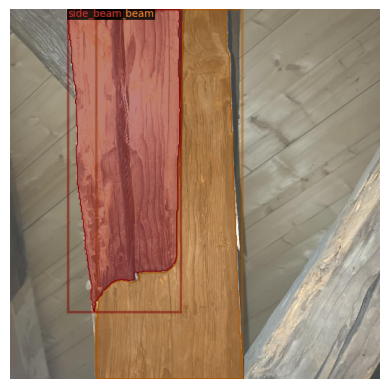

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=9.2431640625.
findfont: score(FontEntry(fname='/home/jpan/miniconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/jpan/miniconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/jpan/miniconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/jpan/miniconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf'

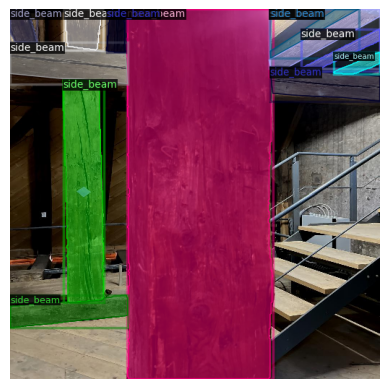

In [5]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])  # Read image in BGR format
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)  # Convert BGR to RGB
    vis = visualizer.draw_dataset_dict(d)
    
    vis_img = vis.get_image()  # Get the visualized image in RGB format
    plt.imshow(vis_img)
    plt.axis('off')  # Hide the axes for better display
    plt.show()
    
# # Visualize some random samples
# for d in random.sample(train_dataset_dicts, 2):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image()[:, :, ::-1])
#     plt.show()


## *Local*

### Data loader(local)

In [9]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wood_train", {}, "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/3_iphone_domini_seg/Dominik-seg.v4i.coco-segmentation/train/_annotations.coco.json", "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/3_iphone_domini_seg/Dominik-seg.v4i.coco-segmentation/train")
register_coco_instances("wood_val", {}, "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/3_iphone_domini_seg/Dominik-seg.v4i.coco-segmentation/valid/_annotations.coco.json", "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/3_iphone_domini_seg/Dominik-seg.v4i.coco-segmentation/valid")

train_metadata = MetadataCatalog.get("wood_train")
train_dataset_dicts = DatasetCatalog.get("wood_train")

val_metadata = MetadataCatalog.get("wood_val")
val_dataset_dicts = DatasetCatalog.get("wood_val")


WARNING [06/27 14:04:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/27 14:04:48 d2.data.datasets.coco]: Loaded 1113 images in COCO format from /Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/3_iphone_domini_seg/Dominik-seg.v4i.coco-segmentation/train/_annotations.coco.json
WARNING [06/27 14:04:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/27 14:04:48 d2.data.datasets.coco]: Loaded 107 images in COCO format from /Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/3_iphone_domini_seg/Dominik-seg.v4i.coco-segmentation/valid/_annotations.coco.json


### Check sample(local)

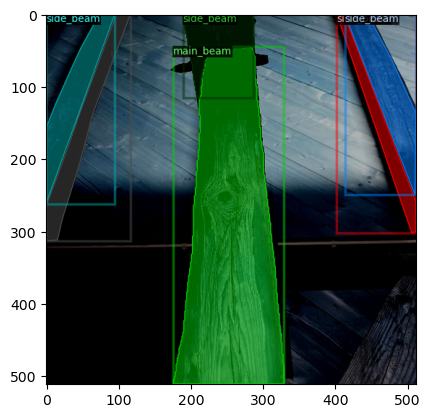

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=9.2431640625.
findfont: score(FontEntry(fname='/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
findfont: score(FontEntry(fname='/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/holmes/anaconda3/envs/test/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXS

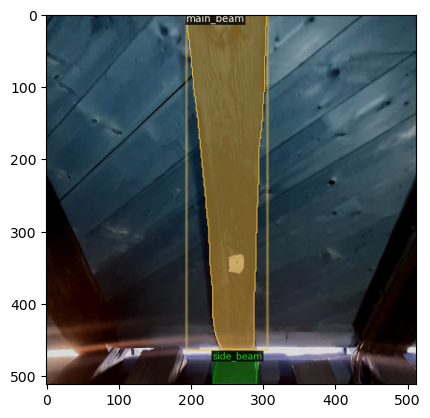

In [10]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# **Training**

## *Train(server)*

In [6]:
import torch
torch.cuda.empty_cache()
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Model Config .yaml

In [17]:
project_name="detectron2"

# # model rcnn r50 fpn 3x
# task_name="test_r50_11_0617"
# model_name = "mask_rcnn_R_50_FPN_3x"
# model_config = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

# model rcnn r101 fpn 3x
task_name="r101_test_6_0618_server"
model_name = "mask_rcnn_R_101_FPN_3x"
model_config = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"


### Model Config .py

In [15]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig


# model rcnn r 50 fpn using Large-Scale Jitter and Longer Training Schedule
task_name="r50_400_test_1_0618_server"
model_name = "mask_rcnn_R_50_FPN_400ep_LSJ"
model_config = "/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

# # model rcnn x101 fpn using Large-Scale Jitter and Longer Training Schedule
# task_name="test_x101_11_0617_local"
# model_name = "mask_rcnn_R_101_FPN_400ep_LSJ.py"
# model_config = "/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/detectron2/detectron2/model_zoo/configs/new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py"

# cfg = LazyConfig.to_py(get_config("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.py"))

# cfg = LazyConfig.load(model_config)
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig

cfg = get_config("new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py")

print(cfg)


{'dataloader': {'train': {'dataset': {'names': 'coco_2017_train', '_target_': <function get_detection_dataset_dicts at 0x319a11300>}, 'mapper': {'is_train': True, 'augmentations': [{'min_scale': 0.1, 'max_scale': 2.0, 'target_height': 1024, 'target_width': 1024, '_target_': <class 'detectron2.data.transforms.augmentation_impl.ResizeScale'>}, {'crop_size': [1024, 1024], '_target_': <class 'detectron2.data.transforms.augmentation_impl.FixedSizeCrop'>}, {'horizontal': True, '_target_': <class 'detectron2.data.transforms.augmentation_impl.RandomFlip'>}], 'image_format': 'BGR', 'use_instance_mask': True, '_target_': <class 'detectron2.data.dataset_mapper.DatasetMapper'>, 'recompute_boxes': True}, 'total_batch_size': 64, 'num_workers': 4, '_target_': <function build_detection_train_loader at 0x319a12340>}, 'test': {'dataset': {'names': 'coco_2017_val', 'filter_empty': False, '_target_': <function get_detection_dataset_dicts at 0x319a11300>}, 'mapper': {'is_train': False, 'augmentations': [{'

### Save .csv

In [19]:
import math

Dataset_version = "v1"
train_amount = 1113
img_per_batch = 16
max_iter = 20869
total_epoch =  math.ceil(max_iter / (train_amount // img_per_batch))
base_lr = 0.00025
poly_power = 1

# test_record_csv = "/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/detectron2_test_record.csv"

# # Save in csv
# new_row = [
#     task_name,
#     model_name,
#     Dataset_version,
#     train_amount,
#     img_per_batch,
#     max_iter,
#     total_epoch,
#     base_lr,
#     poly_power,
#     "none"
# ]

# df = pd.read_csv(test_record_csv, header=None)

# df.loc[len(df)] = new_row

# df.to_csv(test_record_csv, header=False, index=False)

### config .yaml

In [21]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg['OUTPUT_DIR'] = rf"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/{task_name}"
output_directory = cfg['OUTPUT_DIR']
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

cfg.merge_from_file(model_zoo.get_config_file(model_config))
cfg.MODEL.DEVICE = "cpu"

cfg.DATASETS.TRAIN = ("wood_train",)
cfg.DATASETS.TEST = ("wood_val",)
cfg.DATALOADER.NUM_WORKERS = 2 # number of data loading threads
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = img_per_batch # images per batch
cfg.SOLVER.BASE_LR = base_lr # learning rate
cfg.SOLVER.MAX_ITER = max_iter # iterations
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

# # save the configuration
# import yaml

# config_yaml_path = rf"/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/{task_name}/config.yaml"
# directory = os.path.dirname(config_yaml_path)

# if not os.path.exists(directory):
#     os.makedirs(directory)

# with open(config_yaml_path, 'w') as file:
#     yaml.dump(cfg, file)
    

[06/27 14:07:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

### Config .py

In [9]:
from detectron2.engine import DefaultTrainer

cfg.train.output_dir = rf"/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/{task_name}"
output_directory = cfg.train.output_dir
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

cfg.dataloader.train.dataset.names = "wood_train"
cfg.dataloader.test.dataset.names = "wood_val"
cfg.dataloader.evaluator.dataset_name = "wood_test"

cfg.dataloader.train.dataset._target_ = "wood_train"
cfg.dataloader.train._target_ = "wood_train"

cfg.dataloader.test.dataset._target_ = "wood_val"
cfg.dataloader.test._target_ = "wood_val"

cfg.dataloader.train.total_batch_size = img_per_batch
cfg.dataloader.train.num_workers = 3
cfg.train.max_iter = max_iter
cfg.optimizer.lr = base_lr
# cfg.optimizer.weight_decay = None

cfg.model.roi_heads.num_classes = 3
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.train.output_dir, exist_ok=True)

# !
# trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
# trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

# # save the configuration
# import yaml

# config_yaml_path = rf"/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/{task_name}/config.yaml"
# directory = os.path.dirname(config_yaml_path)

# if not os.path.exists(directory):
#     os.makedirs(directory)

# with open(config_yaml_path, 'w') as file:
#     yaml.dump(cfg, file)

print(cfg)

{'dataloader': {'train': {'dataset': {'names': 'wood_train', '_target_': 'wood_train'}, 'mapper': {'is_train': True, 'augmentations': [{'min_scale': 0.1, 'max_scale': 2.0, 'target_height': 1024, 'target_width': 1024, '_target_': <class 'detectron2.data.transforms.augmentation_impl.ResizeScale'>}, {'crop_size': [1024, 1024], '_target_': <class 'detectron2.data.transforms.augmentation_impl.FixedSizeCrop'>}, {'horizontal': True, '_target_': <class 'detectron2.data.transforms.augmentation_impl.RandomFlip'>}], 'image_format': 'BGR', 'use_instance_mask': True, '_target_': <class 'detectron2.data.dataset_mapper.DatasetMapper'>, 'recompute_boxes': True}, 'total_batch_size': 16, 'num_workers': 3, '_target_': 'wood_train'}, 'test': {'dataset': {'names': 'wood_val', 'filter_empty': False, '_target_': 'wood_val'}, 'mapper': {'is_train': False, 'augmentations': [{'short_edge_length': 800, 'max_size': 1333, '_target_': <class 'detectron2.data.transforms.augmentation_impl.ResizeShortestEdge'>}], 'ima

In [ ]:
print(cfg.dataloader.train.dataset.names)
print(cfg.dataloader.test.dataset.names)
print(cfg.dataloader.train)


In [10]:
import logging

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import LazyConfig, instantiate
from detectron2.engine import (
    AMPTrainer,
    SimpleTrainer,
    default_setup,
    default_writers,
    hooks,
    launch,
)
from detectron2.engine.defaults import create_ddp_model
from detectron2.evaluation import inference_on_dataset, print_csv_format
from detectron2.utils import comm

logger = logging.getLogger("detectron2")

class Args:
    config_file = model_config
    resume = False
    eval_only = False
    num_gpus = 1
    num_machines = 1
    machine_rank = 0
    dist_url = "tcp://127.0.0.1:50152"
    opts = []

args = Args()

def do_test(cfg, model):
    if "evaluator" in cfg.dataloader:
        ret = inference_on_dataset(
            model,
            instantiate(cfg.dataloader.test),
            instantiate(cfg.dataloader.evaluator),
        )
        print_csv_format(ret)
        return ret

def do_train(args, cfg):
    model = instantiate(cfg.model)
    logger = logging.getLogger("detectron2")
    logger.info("Model:\n{}".format(model))
    model.to(cfg.train.device)
    print("model")
    
    cfg.optimizer.params.model = model
    optim = instantiate(cfg.optimizer)
    print("model2")


    train_loader = instantiate(cfg.dataloader.train)
    print("model3")


    model = create_ddp_model(model, **cfg.train.ddp)
    trainer = (AMPTrainer if cfg.train.amp.enabled else SimpleTrainer)(model, train_loader, optim)
    checkpointer = DetectionCheckpointer(
        model,
        cfg.train.output_dir,
        trainer=trainer,
    )
    trainer.register_hooks(
        [
            hooks.IterationTimer(),
            hooks.LRScheduler(scheduler=instantiate(cfg.lr_multiplier)),
            (
                hooks.PeriodicCheckpointer(checkpointer, **cfg.train.checkpointer)
                if comm.is_main_process()
                else None
            ),
            hooks.EvalHook(cfg.train.eval_period, lambda: do_test(cfg, model)),
            (
                hooks.PeriodicWriter(
                    default_writers(cfg.train.output_dir, cfg.train.max_iter),
                    period=cfg.train.log_period,
                )
                if comm.is_main_process()
                else None
            ),
        ]
    )

    checkpointer.resume_or_load(cfg.train.init_checkpoint, resume=args.resume)
    if args.resume and checkpointer.has_checkpoint():
        start_iter = trainer.iter + 1
    else:
        start_iter = 0
    trainer.train(start_iter, cfg.train.max_iter)

def main(args):
    cfg = LazyConfig.load(args.config_file)
    cfg = LazyConfig.apply_overrides(cfg, args.opts)
    default_setup(cfg, args)

    if args.eval_only:
        model = instantiate(cfg.model)
        model.to(cfg.train.device)
        model = create_ddp_model(model)
        DetectionCheckpointer(model).load(cfg.train.init_checkpoint)
        print(do_test(cfg, model))
    else:
        do_train(args, cfg)

# 在 Jupyter Notebook 中运行
if __name__ == "__main__":
    main(args)


[06/19 16:25:03 detectron2]: Rank of current process: 0. World size: 1
[06/19 16:25:03 detectron2]: Rank of current process: 0. World size: 1
[06/19 16:25:03 detectron2]: Environment info:
-------------------------------  --------------------------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
numpy                            1.26.4
detectron2                       0.6 @/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/detectron2/detectron2
detectron2._C                    not built correctly: No module named 'detectron2._C'
Compiler ($CXX)                  c++ (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
CUDA compiler                    Cuda compilation tools, release 10.1, V10.1.243
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.3.1+cu121 @/home/jpan/min

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/coco/annotations/instances_train2017.json'

In [11]:
print(cfg)

{'dataloader': {'train': {'dataset': {'names': 'wood_train', '_target_': 'wood_train'}, 'mapper': {'is_train': True, 'augmentations': [{'min_scale': 0.1, 'max_scale': 2.0, 'target_height': 1024, 'target_width': 1024, '_target_': <class 'detectron2.data.transforms.augmentation_impl.ResizeScale'>}, {'crop_size': [1024, 1024], '_target_': <class 'detectron2.data.transforms.augmentation_impl.FixedSizeCrop'>}, {'horizontal': True, '_target_': <class 'detectron2.data.transforms.augmentation_impl.RandomFlip'>}], 'image_format': 'BGR', 'use_instance_mask': True, '_target_': <class 'detectron2.data.dataset_mapper.DatasetMapper'>, 'recompute_boxes': True}, 'total_batch_size': 16, 'num_workers': 3, '_target_': 'wood_train'}, 'test': {'dataset': {'names': 'wood_val', 'filter_empty': False, '_target_': 'wood_val'}, 'mapper': {'is_train': False, 'augmentations': [{'short_edge_length': 800, 'max_size': 1333, '_target_': <class 'detectron2.data.transforms.augmentation_impl.ResizeShortestEdge'>}], 'ima

### clearml

In [ ]:
#clearml mac
# %env CLEARML_WEB_HOST=https://app.clear.ml
# %env CLEARML_API_HOST=https://api.clear.ml
# %env CLEARML_FILES_HOST=https://files.clear.ml
# %env CLEARML_API_ACCESS_KEY=QO1VBBX9J2S2VYILQTGI
# %env CLEARML_API_SECRET_KEY=ERuc1S6o5SirQGugvYXDFjH9b9aNi0u8S3rpALzXMa8YPSLDMW

# clearml win
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=Z4YDBU13VPOFHBHF8667
%env CLEARML_API_SECRET_KEY=JMzvRXn76AT83WuFJfS0FBGCY8c5TccbH5XboTYztrWqwzDdyn

from clearml import Task

#Clear ML Initialization
cl_task = Task.init(project_name=project_name,task_name=task_name)
logger = cl_task.get_logger()

### Train

In [ ]:
trainer.train() #Start the training process
cl_task.close()

# Inference & evaluation using the trained model

In [27]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Function to convert binary masks to polygons      
def binary_mask_to_polygons(binary_mask, tolerance=1):
    polygons = []
    # Convert boolean mask to uint8
    binary_mask = binary_mask.astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if len(contour) > 4:
            contour = contour.flatten().tolist()
            polygons.append([[contour[i], contour[i + 1]] for i in range(0, len(contour), 2)])
    return polygons


[06/27 14:13:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/model_final.pth ...
[Checkpointer] Loading from /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/model_final.pth ...


## Verify segmentation on random validation images

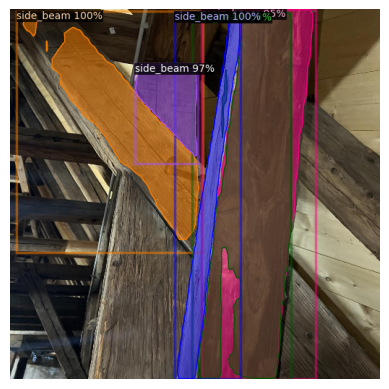

In [25]:
# Randomly select one image from validation dataset and visualize predictions
for d in random.sample(val_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])  # Read image in BGR format
    im_rgb = im[:, :, ::-1]  # Convert BGR to RGB
    outputs = predictor(im_rgb)  # Get predictions from the model
    
    # Create a Visualizer instance
    v = Visualizer(im_rgb,  # Use RGB image
                   metadata=val_metadata,
                   scale=0.5,
                   # instance_mode=ColorMode.IMAGE_BW  # Optionally remove colors of unsegmented pixels
    )
    
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Get the visualized image in RGB format
    out_img = out.get_image()
    
    # Display the image using matplotlib
    plt.imshow(out_img)
    plt.axis('off')  # Hide the axes for better display
    plt.show()
    
    # Save the output image
    original_file_name = os.path.basename(d["file_name"])
    new_file_name = f"test_{original_file_name}"
    output_file_path = os.path.join(cfg.OUTPUT_DIR, new_file_name)
    plt.imsave(output_file_path, out_img)  # Save as RGB format


## Export with json

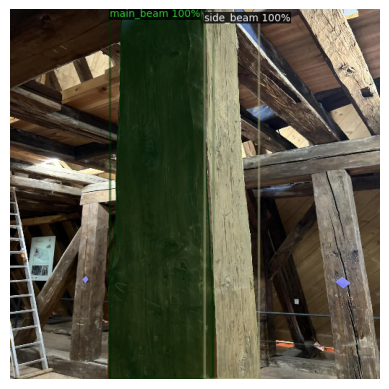

In [22]:
import random
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode


# Randomly select one image from validation dataset and visualize predictions
for d in random.sample(val_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])  # Read image in BGR format
    im_rgb = im[:, :, ::-1]  # Convert BGR to RGB
    outputs = predictor(im_rgb)  # Get predictions from the model
    
    # Create a Visualizer instance
    v = Visualizer(im_rgb,  # Use RGB image
                   metadata=val_metadata,
                   scale=0.5,
                   # instance_mode=ColorMode.IMAGE_BW  # Optionally remove colors of unsegmented pixels
    )
    
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Get the visualized image in RGB format
    out_img = out.get_image()
    
    # Display the image using matplotlib
    plt.imshow(out_img)
    plt.axis('off')  # Hide the axes for better display
    plt.show()
    
    # Save the output image
    original_file_name = os.path.basename(d["file_name"])
    new_file_name = f"test_{original_file_name}"
    output_file_path = os.path.join(cfg.OUTPUT_DIR, new_file_name)
    plt.imsave(output_file_path, out_img)  # Save as RGB format
    
    # Save the detection results as JSON
    instances = outputs["instances"].to("cpu")
    pred_classes = instances.pred_classes.tolist()
    pred_boxes = instances.pred_boxes.tensor.tolist()
    pred_scores = instances.scores.tolist()
    
    # Extract masks and convert to polygons
    pred_masks = instances.pred_masks.numpy()
    pred_polygons = [binary_mask_to_polygons(mask) for mask in pred_masks]
    
    # Organize results per instance
    detection_results = []
    for cls, box, score, polygons in zip(pred_classes, pred_boxes, pred_scores, pred_polygons):
        instance_result = {
            "class": cls,
            "box": box,
            "score": score,
            "mask": [{"polygon": polygon} for polygon in polygons]
        }
        detection_results.append(instance_result)
    
    result_dict = {
        "file_name": d["file_name"],
        "instances": detection_results
    }
    
    json_file_name = f"test_{original_file_name.split('.')[0]}.json"
    json_output_file_path = os.path.join(cfg.OUTPUT_DIR, json_file_name)
    with open(json_output_file_path, 'w') as json_file:
        json.dump(result_dict, json_file, indent=4)


## Export folder results with json

In [31]:
input_folder = '/Users/holmes/Documents/UNI-Bamberg/Arbeiten/RAW-DATA/FARO_pano_pc'
output_folder = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/more_test'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for file_name in os.listdir(input_folder):
    file_path = os.path.join(input_folder, file_name)
    if file_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        im = cv2.imread(file_path)  # Read image in BGR format
        if im is None:
            continue
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        outputs = predictor(im_rgb)  # Get predictions from the model
        
        v = Visualizer(im_rgb, metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        out_img = out.get_image()[:, :, ::-1]  # Convert RGB to BGR for OpenCV

        # plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.show()

        test_name = f"det_seg_{file_name}"

        output_image_path = os.path.join(output_folder, f"{test_name}")
        cv2.imwrite(output_image_path, out_img)

        # save JSON
        instances = outputs["instances"].to("cpu")
        pred_classes = instances.pred_classes.tolist()
        pred_boxes = instances.pred_boxes.tensor.tolist()
        pred_scores = instances.scores.tolist()
        pred_masks = instances.pred_masks.numpy()
        pred_polygons = [binary_mask_to_polygons(mask) for mask in pred_masks]

        detection_results = []
        for cls, box, score, polygons in zip(pred_classes, pred_boxes, pred_scores, pred_polygons):
            instance_result = {
                "class": cls,
                "box": box,
                "score": score,
                "mask": [{"polygon": polygon} for polygon in polygons]
            }
            detection_results.append(instance_result)
        
        result_dict = {
            "file_name": file_name,
            "instances": detection_results
        }
        
        json_output_file_path = os.path.join(output_folder, f"{test_name.split('.')[0]}.json")
        with open(json_output_file_path, 'w') as json_file:
            json.dump(result_dict, json_file, indent=4)


### Others

In [ ]:
def run_inference_on_custom_image(image_path, output_dir, predictor, val_metadata):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW  
    )
    
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    
    original_file_name = os.path.basename(image_path)
    new_file_name = f"test_{original_file_name}"
    output_file_path = os.path.join(output_dir, new_file_name)
    plt.savefig(output_file_path, bbox_inches='tight', pad_inches=0)
    # plt.close() 

custom_image_path = "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test/Model_3_0020_jpeg.rf.b1ada19a12423f765881f57d7f2223d6.jpg" 
output_dir = cfg.OUTPUT_DIR
run_inference_on_custom_image(custom_image_path, output_dir, predictor, val_metadata)


## Test on mac

## Further check

Check average precision and recall. (Need more validation data than just 2 images with handful of annotations)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wood_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "wood_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

**Load a new image and segment it.**

In [ ]:
new_im = cv2.imread(r"B:\01_Study\Uni-Bamberg\Work\Holzprojects\Datasets_local\03_Domini_ip13\Dominik-seg.v4i.coco-segmentation\test\Model_5_0016_jpeg.rf.04622e1c6175ec13b0be7f653916a02d.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.imshow(out.get_image()[:, :, ::-1])

**Process multiple images in a directory and save the results in an output directory**

In [ ]:
# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


**Segment images and save object level information into a csv file.**




In [ ]:
import csv
from skimage.measure import regionprops, label


# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test"

# Output directory where the CSV file will be saved
output_csv_path = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results/output_objects.csv"  # Replace this with the path to your desired output CSV file

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])  # Add more columns as needed for other properties

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Debugging: print class_labels and metadata.thing_classes
        #print("Class Labels:", class_labels)
        #print("Thing Classes:", train_metadata.thing_classes)

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1  # Object number starts from 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = train_metadata.thing_classes[class_label]
            else:
                # If class label is not available (should not happen), use 'Unknown' as class name
                class_name = 'Unknown'

            # Write the object-level information to the CSV file
            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])  # Add more columns as needed for other properties

print("Object-level information saved to CSV file.")


**Generate plots to understand the objects**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the CSV file containing the object-level information
csv_file_path = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results/output_objects.csv"  # Update with your CSV file path

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Get class names from train_metadata.thing_classes
class_names = train_metadata.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()




**Saving binary (actually multinary) images for each class for further processing.** Here, for each input image we will save n images corresponding to the number of classes. In our example, we will save 4 images for each image corresponding to the 4 classes. Each of these images will contain objects numbered 1, 2, 3, etc. - basically instance segmentation like images. These images can be used for further downstream processing.

In [ ]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results_instance"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                   for class_name in train_metadata.thing_classes}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = train_metadata.thing_classes[pred_class]
        class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                              i + 1,
                                              class_masks[class_name])

    # Save the masks for each class with unique integer labels
    for class_name, class_mask in class_masks.items():
        # Convert the tensor to a NumPy array and then to a regular (CPU) array
        class_mask_np = class_mask.cpu().numpy()

        # Create the output filename with _class_name_result.png extension
        class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
        class_output_path = os.path.join(output_directory, class_filename)

        # Save the image with unique integer labels
        cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))

print("Segmentation of all images completed.")


# END

**Interested in panoptic segmentation?**

In [ ]:
my_new_image = cv2.imread("/content/drive/MyDrive/ColabNotebooks/data/street_small.jpg")
cv2_imshow(my_new_image)

In [ ]:
# Inference with instance segmentation
cfg_inst = get_cfg()
cfg_inst.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_inst.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg_inst.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg_inst)
outputs = predictor(new_im)

v = Visualizer(new_im[:, :, ::-1], MetadataCatalog.get(cfg_inst.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

**Panoptic segmentation = Instance segmentation + Semantic Segmentation**





In [ ]:
# Inference with a panoptic segmentation model
cfg_pan = get_cfg()
cfg_pan.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg_pan.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg_pan)
panoptic_seg, segments_info = predictor(new_im)["panoptic_seg"]
v = Visualizer(new_im[:, :, ::-1], MetadataCatalog.get(cfg_pan.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.imshow(out.get_image()[:, :, ::-1])